# Custom KAN Layer

In [1]:
import torch
import torch.nn as nn

The library is set up for easy implementation of new custom KAN layer types.
In this tutorial we will implement a layer with piecewise linear activation functions $\phi$

All layers should inherit from the **KanLayerBase** class and implement at least the *.compute_activations()* method:
```python
class KanLayerBase8(nn.Module):
    def compute_activations(self, x:torch.Tensor) -> torch.Tensor:
            """Compute activation matrix.
            
            Args:
                x (torch.Tensor): input tensor of shape (*, in_features)

            Returns:
                torch.Tensor: activation matrix of shape (*, out_features, in_features)
            """
            pass
```
As depicted above, the method receives the activations from the previous layer and should output all activations for the current layer. You do not need to sum over the input dimension, since this will be handled by the *.forward()* method of the base class.

For an easy implementation we will define the support points of the piecewise linear functions with fixed x-coordinates and learnable y-coordinates. 

In [2]:
from torch import Tensor
from tkan.nn.base import KanLayerBase

class PiecwiseLinearKanLayer(KanLayerBase):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        pieces: int = 4
    ) -> None:
        super().__init__(in_features, out_features)
        self.pieces = pieces
        self.ys = nn.Parameter(torch.rand((out_features, in_features, pieces + 1)))



    def compute_activations(self, t: Tensor) -> Tensor:
        # map to to the range [0, #pieces]
        t = t.view(t.size(0), 1, self.in_features, 1)
        t = (t + 1) / 2 * self.pieces
        ids = torch.floor(t).long().clamp_(0, self.pieces - 1)

        ys = self.ys[None].repeat_interleave(t.size(0), 0)
        left  = torch.gather(ys, -1, ids)
        right = torch.gather(ys, -1, ids + 1)
        fac = t - ids
        return (left + fac * (right - left)).squeeze(-1)


x = torch.rand((128, 2))
layer = PiecwiseLinearKanLayer(2, 1)
y = layer(x)
print(f"Layer: {x.shape} -> {y.shape}")

Layer: torch.Size([128, 2]) -> torch.Size([128, 1])


That is all we need to do to implement our custom KAN layer. We can now use this in any nn.Sequential KAN model and plotting, as well as initialization with a given non-linearity will work out of the box.

## Pruning

To enable pruning for our custom layer we need to implement the *.get_pruned()* method. It receives a list of input and output features to keep and returns a new layer with only those features:

```python
def get_pruned(self, in_features: list[int], out_features: list[int]) -> KanLinearBase:
    """Return a smaller Layer with only the given in and out features.
    
    Args:
        in_features (list[int]): list of in features to keep
        out_features (list[int]): list of out features to keep

    Returns:
        nn.Module: a new layer with only the given in and out features
    """
```

In [3]:
class PiecwiseLinearKanLayerV2(PiecwiseLinearKanLayer):  
    def get_pruned(self, in_features: list[int], out_features: list[int]) -> 'PiecwiseLinearKanLayerV2':
        layer = PiecwiseLinearKanLayerV2(len(in_features), len(out_features), self.pieces)
        layer.ys.data = self.ys[out_features][:, in_features]
        return layer
    
original_layer = PiecwiseLinearKanLayerV2(4, 2)
active_in_features = [0, 2, 3]
active_out_features = [1]
pruned_layer = original_layer.get_pruned(active_in_features, active_out_features)

print(f"Original Layer:  {original_layer}")
print(f"Pruned Layer:    {pruned_layer}")

Original Layer:  PiecwiseLinearKanLayerV2[4, 2]
Pruned Layer:    PiecwiseLinearKanLayerV2[3, 1]


## Plotting

Plotting will be supported out of the box. However, if we want to change how the activations are displayed, we overwrite the *.plot_activation()* method.


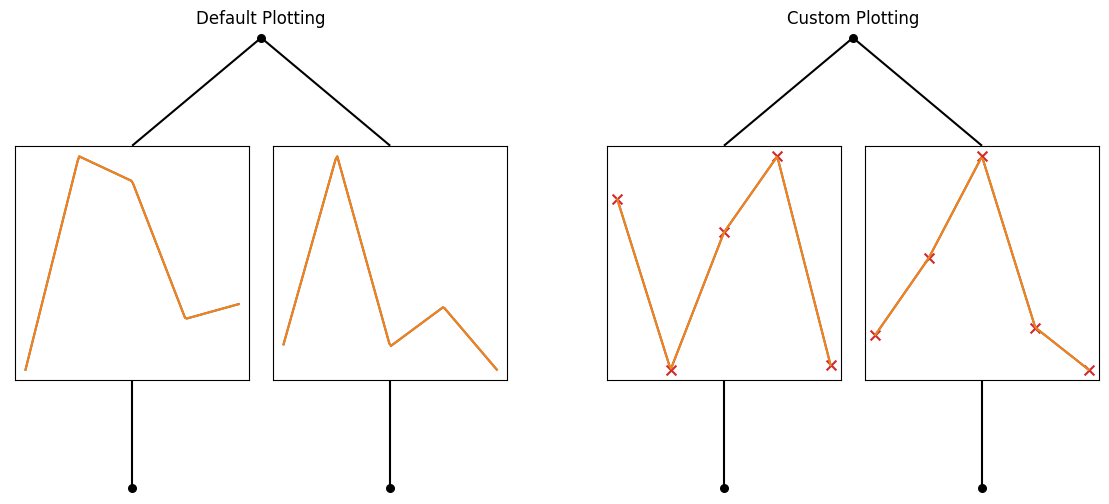

In [4]:
import matplotlib.pyplot as plt
from tkan.plotting import plot_kan

class PiecwiseLinearKanLayerV3(PiecwiseLinearKanLayer):
    @torch.inference_mode()  
    def plot_activation(
        self, 
        activation_id: tuple[int, int], 
        ax: plt.Axes | None = None, 
        n: int = 128, 
        trange: tuple[int, int] | None = None, 
        **kwargs
    ) -> None:
        # We call super plot the function graph itself
        super().plot_activation(
            activation_id=activation_id, 
            ax=ax, 
            n=n, 
            trange=trange, 
            **kwargs
        )

        # If no axis is given, we get the active axis
        ax = ax or plt.gca()

        # Now we can draw the support points of the piecewise linear function
        out_id, in_id = activation_id
        xs = torch.linspace(-1, 1, self.pieces + 1)
        ys = self.ys[out_id, in_id].cpu()
        plt.scatter(xs, ys, marker='x', color='tab:red', s=50)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plot_kan(PiecwiseLinearKanLayer(2, 1), ax=ax1)
ax1.set_title("Default Plotting")
plot_kan(PiecwiseLinearKanLayerV3(2, 1), ax=ax2)
ax2.set_title("Custom Plotting")

plt.show()

## Initialization

The default implementation of initialization uses gradient decent to approximate the activations. This is potentially slow and inaccurate. We can implement a custom initialization by overriding the *.init_with_non_linearity()* method. 

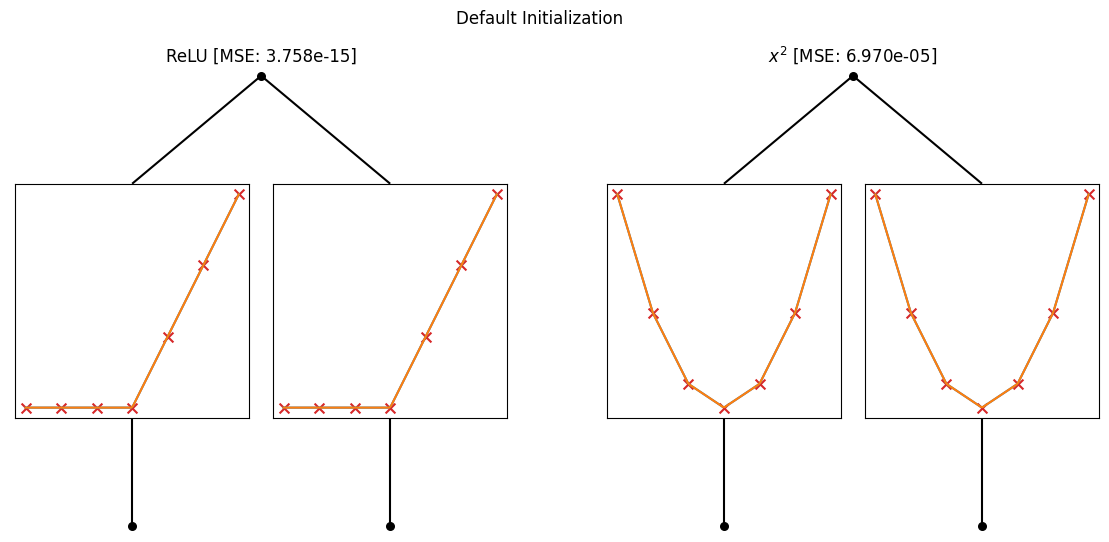

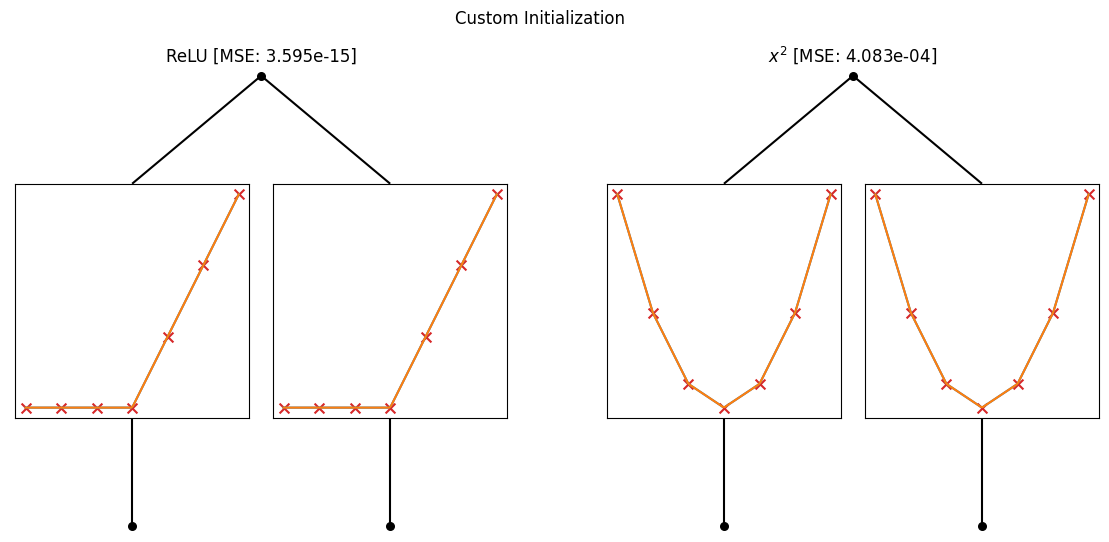

In [5]:
from typing import Callable
from tkan.nn.init import init_with_non_linearity

class PiecwiseLinearKanLayerV4(PiecwiseLinearKanLayerV3):
    def init_with_non_linearity(
        self, 
        non_linearity: Callable[[torch.Tensor], torch.Tensor], 
        domain: tuple[int, int] = (-1, 1)
    ) -> float:
        xs = torch.linspace(domain[0], domain[1], self.pieces + 1, device=self.ys.device).view(1, 1, 1, -1).repeat(1, self.out_features, self.in_features, 1)[0]
        self.ys.data = non_linearity(xs)

        # Compute approximation mse
        xs = torch.linspace(domain[0], domain[1], 128, device=self.ys.device)
        ys = non_linearity(xs.view(-1, 1, 1).repeat(1, self.out_features, self.in_features))
        acts = self.compute_activations(xs.view(-1, 1).repeat(1, self.in_features))
        return (ys - acts).square().mean().item()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
default_layer = PiecwiseLinearKanLayerV3(2, 1, pieces=6)
relu_mse = init_with_non_linearity(default_layer, torch.relu)
plot_kan(default_layer, ax=ax1)
ax1.set_title(f"ReLU [MSE: {relu_mse:.3e}]")

square_mse = init_with_non_linearity(default_layer, lambda x: x**2)
plot_kan(default_layer, ax=ax2)
ax2.set_title(f"$x^2$ [MSE: {square_mse:.3e}]")
fig.suptitle("Default Initialization")
plt.show()


layer = PiecwiseLinearKanLayerV4(2, 1, pieces=6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

relu_mse = init_with_non_linearity(layer, torch.relu)
plot_kan(layer, ax=ax1)
ax1.set_title(f"ReLU [MSE: {relu_mse:.3e}]")

square_mse = init_with_non_linearity(layer, lambda x: x**2)
plot_kan(layer, ax=ax2)
ax2.set_title(f"$x^2$ [MSE: {square_mse:.3e}]")
fig.suptitle("Custom Initialization")
plt.show()
